### Followed tutorial from https://machinelearningmastery.com/multivariate-time-series-forecasting-lstms-keras/

28-Oct-21

Differencing: https://machinelearningmastery.com/difference-time-series-dataset-python/
Detecting Outliers: https://towardsdatascience.com/ways-to-detect-and-remove-the-outliers-404d16608dba
Data Visualization: https://towardsdatascience.com/data-visualization-for-machine-learning-and-data-science-a45178970be7

Try out LSTMs from these 2 videos:
https://www.youtube.com/watch?v=tepxdcepTbY
https://www.youtube.com/watch?v=4FmVIpcwl4k


# Importing the libraries


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import LSTM
from math import sqrt

Using TensorFlow backend.


In [2]:
#Importing the Dataset
dataset = pd.read_csv('2021_10_24_cleaned_lake_dataset.csv', header=0, index_col=0)
dataset = dataset.rename(columns={'actual_conductivity':'cond', 'do_concentration':'do', 'turbidity':'turb', 'chl-a_concentration':'chl-a', 'temperature':'temp'})
dataset = dataset[['temp', 'cond', 'do', 'turb', 'chl-a']]
# dataset = dataset.diff()
# dataset = dataset.dropna()
dataset.head()

,temp,cond,do,turb,chl-a
datetime,,,,,
2019-02-20 12:00:00,29.55674,92.12651,6.491213,32.86783,39.64875
2019-02-20 12:10:00,29.59175,92.22813,6.724226,24.30492,40.57396
2019-02-20 12:20:00,29.57693,91.93182,6.677357,47.46174,40.88269
2019-02-20 12:30:00,29.63118,92.45161,7.540924,55.04100,46.67803
2019-02-20 12:40:00,29.64378,92.78736,7.629431,26.58170,47.05107


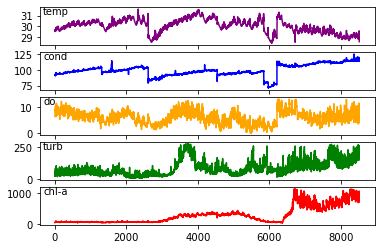

In [3]:
#visualizing subplots of the data
values = dataset.values
groups = [0,1,2,3,4]
colors=['purple', 'blue', 'orange', 'green',  'red']
column_names = ['temperature','conductivity', 'do', 'turbidity', 'chl-a']
i = 1

plt.figure()
for group  in groups:
    plt.subplot(len(groups), 1, i)
    plt.plot(values[:,group], color = colors[i-1])
    plt.title(dataset.columns[group], x=0.01, y=0.65, loc='left', fontsize = 10)
    i += 1
plt.show()

In [200]:
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = pd.DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = pd.concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

In [650]:
#Data Preprocessing
#Ascertain all data is float
values = values.astype('float32')

#Normalizing Features
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(values)
scaled_df = pd.DataFrame(scaled_data)
scaled_df.tail()
#print(scaled_df.shape)

,0,1,2,3,4
8511,0.158947,0.806835,0.435342,0.594493,0.859802
8512,0.360244,0.898873,0.882970,0.680489,0.910041
8513,0.227575,0.819773,0.550004,0.922851,0.915309
8514,0.134986,0.811672,0.508795,0.876128,0.939753
8515,0.044427,0.802803,0.309270,0.946511,0.674118


In [691]:
#specifying lag intervals
n_intervals = 2
reframed = series_to_supervised(scaled_df, n_intervals, 2)
reframed = reframed.drop(columns = [ 'var5(t-2)', 'var5(t)'])
#reframed = reframed.drop(columns = [ 'var5(t-2)', 'var5(t-1)']) #'var5(t-8)','var5(t-7)','var5(t-6)','var5(t-5)','var5(t-4)','var5(t-3)',
reframed.head()
#print(reframed.shape)

,var1(t-2),var2(t-2),var3(t-2),var4(t-2),var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var1(t),var2(t),var3(t),var4(t),var1(t+1),var2(t+1),var3(t+1),var4(t+1),var5(t+1)
2,0.346690,0.386120,0.490420,0.088498,0.357907,0.387985,0.508342,0.055884,0.014179,0.353159,0.382547,0.504737,0.144082,0.370543,0.392087,0.571157,0.172949,0.019722
3,0.357907,0.387985,0.508342,0.055884,0.353159,0.382547,0.504737,0.144082,0.014459,0.370543,0.392087,0.571157,0.172949,0.374579,0.398249,0.577965,0.064556,0.020060
4,0.353159,0.382547,0.504737,0.144082,0.370543,0.392087,0.571157,0.172949,0.019722,0.374579,0.398249,0.577965,0.064556,0.370950,0.379910,0.573125,0.093611,0.018433
5,0.370543,0.392087,0.571157,0.172949,0.374579,0.398249,0.577965,0.064556,0.020060,0.370950,0.379910,0.573125,0.093611,0.374974,0.375992,0.599715,0.164791,0.018612
6,0.374579,0.398249,0.577965,0.064556,0.370950,0.379910,0.573125,0.093611,0.018433,0.374974,0.375992,0.599715,0.164791,0.384766,0.369648,0.654422,0.112486,0.024883


In [700]:
#Train-Test Split
values = reframed.values
n_train = 7513             #leaving 1000 data points for testing

train = values[:n_train, :]
test = values[n_train:,:]

train_X = train[:,:-1]
train_y = train[:,-1]

test_X = test[:,:-1]
test_y = test[:,-1]

# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))

print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(7513, 1, 17) (7513,) (1000, 1, 17) (1000,)


In [701]:
#Designing the LSTM Network

model = Sequential()
model.add(LSTM(32, input_shape=(train_X.shape[1], train_X.shape[2]), return_sequences=True)) #, return_sequences=True
#model.add(LSTM(8, return_sequences=True)) #activation = 'sigmoid',
model.add(LSTM(16, return_sequences=False))

model.add(Dense(1))
#model.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy'])
model.compile(loss='mae', optimizer='adam')
model.summary()

Model: "sequential_146"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_328 (LSTM)              (None, 1, 32)             6400      
_________________________________________________________________
lstm_329 (LSTM)              (None, 16)                3136      
_________________________________________________________________
dense_144 (Dense)            (None, 1)                 17        
Total params: 9,553
Trainable params: 9,553
Non-trainable params: 0
_________________________________________________________________


Epoch 1/80
30/30 - 1s - loss: 0.1281 - val_loss: 0.5257
Epoch 2/80
30/30 - 0s - loss: 0.1371 - val_loss: 0.4924
Epoch 3/80
30/30 - 0s - loss: 0.1326 - val_loss: 0.4617
Epoch 4/80
30/30 - 0s - loss: 0.1272 - val_loss: 0.4242
Epoch 5/80
30/30 - 0s - loss: 0.1248 - val_loss: 0.4032
Epoch 6/80
30/30 - 0s - loss: 0.1187 - val_loss: 0.3738
Epoch 7/80
30/30 - 0s - loss: 0.1134 - val_loss: 0.3419
Epoch 8/80
30/30 - 0s - loss: 0.1065 - val_loss: 0.2967
Epoch 9/80
30/30 - 0s - loss: 0.0988 - val_loss: 0.2336
Epoch 10/80
30/30 - 0s - loss: 0.0886 - val_loss: 0.1431
Epoch 11/80
30/30 - 0s - loss: 0.0767 - val_loss: 0.0781
Epoch 12/80
30/30 - 0s - loss: 0.0654 - val_loss: 0.0806
Epoch 13/80
30/30 - 0s - loss: 0.0551 - val_loss: 0.0729
Epoch 14/80
30/30 - 0s - loss: 0.0514 - val_loss: 0.0672
Epoch 15/80
30/30 - 0s - loss: 0.0502 - val_loss: 0.0640
Epoch 16/80
30/30 - 0s - loss: 0.0500 - val_loss: 0.0608
Epoch 17/80
30/30 - 0s - loss: 0.0481 - val_loss: 0.0625
Epoch 18/80
30/30 - 0s - loss: 0.0419 - 

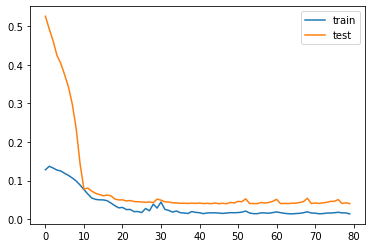

In [702]:
#Fitting the model
history = model.fit(train_X, train_y, epochs=80, batch_size = 256, validation_data = (test_X, test_y), verbose=2, shuffle=False)

# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [703]:
yhat = model.predict(test_X)
yhat_trn = model.predict(train_X)
# calculate RMSE
rmse = sqrt(mean_squared_error(test_y, yhat))
print('Test RMSE: %.3f' % rmse)

rmse = sqrt(mean_squared_error(train_y, yhat_trn))
print('Train RMSE: %.3f' % rmse)

print('Test R2 Score: ', r2_score(test_y, yhat))

print('Train R2 Score: ', r2_score(train_y, yhat_trn))

# test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
# yhat.shape
# invert scaling for forecast
# inv_yhat = np.concatenate((yhat, test_X[:]), axis=1)
#inv_yhat.shape
#inv_yhat = scaler.inverse_transform(inv_yhat)
'''
16-8 LSTM
Test RMSE: 0.061
Train RMSE: 0.027
Test R2 Score:  0.8325227855366825
Train R2 Score:  0.9787086314258545
'''

Test RMSE: 0.052
Train RMSE: 0.027
Test R2 Score:  0.8796785006210539
Train R2 Score:  0.9786871886639252


'\n16-8 LSTM\nTest RMSE: 0.061\nTrain RMSE: 0.027\nTest R2 Score:  0.8325227855366825\nTrain R2 Score:  0.9787086314258545\n'

In [704]:
# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))

# invert scaling for forecast
inv_yhat = np.concatenate((yhat, test_X[:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]

# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = np.concatenate((test_y, test_X[:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

#without 4 lag Test RMSE: 0.351 #batch 32

ValueError: operands could not be broadcast together with shapes (1000,18) (5,) (1000,18) 

In [705]:
actual_y = pd.DataFrame(test_y)
actual_y.head()

,0
0,0.519132
1,0.487749
2,0.475997
3,0.460814
4,0.494149


In [706]:
predicted_y = pd.DataFrame(yhat)
predicted_y.head()

,0
0,0.526947
1,0.544886
2,0.534838
3,0.508919
4,0.501545


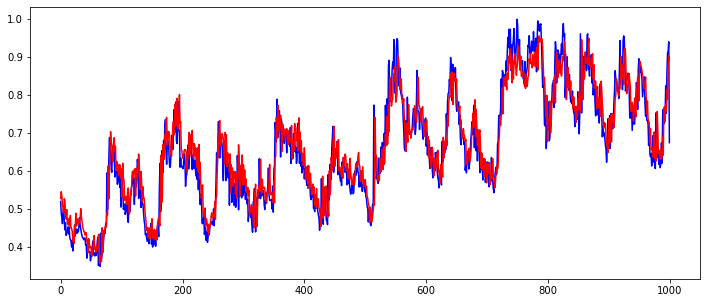

In [707]:
plt.figure(figsize=(12,5))
#plt.xlabel('Actual vs Predicted Chl-a')
#plt.xticks(predicted_y, predicted_y.index.values)

plt.plot(actual_y, color='blue')
plt.plot(predicted_y, color='red')
plt.show()